<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_06_05_survival_analysis_dynamic_joint_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 6.5 Dynamic Joint Models



A **Dynamic Joint Model (Dynamic JM)** is an extension of the standard **shared random effects joint model** that enables real-time, individualized risk prediction for a future event (e.g., death, disease progression) by updating predictions as new longitudinal data (eg. biomarker measurements) become available. In other words, it turns the joint model into a **dynamic prediction tool**, not just a static association estimator.

At any time point $t$ during follow-up, after observing a patient’s longitudinal history $\mathcal{Y}_i(t) = \{ y_i(s) : 0 \leq s \leq t \}$, we can compute the conditional probability of surviving beyond a future time $u > t$\*\*:

$$
\pi_i(u \mid t) = P(T_i > u \mid T_i > t, \mathcal{Y}_i(t), \mathcal{D}_n)
$$

-   $T_i$: event time for subject $i$
-   $\mathcal{Y}_i(t)$: all longitudinal measurements up to time $t$
-   $\mathcal{D}_n$: full dataset used to fit the joint model (provides parameter estimates)
-   $u - t$: prediction horizon (e.g., 6 months, 1 year)

This probability **dynamically updates** as $t$ increases and more biomarker data are collected.


### Why “Dynamic”?


-   **Static models** (e.g., baseline Cox) give one risk estimate at enrollment.
-   **Time-dependent Cox** uses observed biomarker values but ignores measurement error and trajectory.
-   **Dynamic JM** uses the **entire history** of noisy measurements to infer the **true underlying trajectory** (via the mixed model) and **propagates uncertainty** into the survival prediction.


### Mathematical Foundation


Under the standard joint model with **current-value association**, the dynamic survival probability is:

$$
\pi_i(u \mid t) = \frac{
  \int P(T_i > u \mid b_i, \theta_S) \cdot p(b_i \mid T_i > t, \mathcal{Y}_i(t), \theta)
  \, db_i
}{
  \int P(T_i > t \mid b_i, \theta_S) \cdot p(b_i \mid \mathcal{Y}_i(t), \theta_L)
  \, db_i
}
$$

-   The numerator: probability of surviving beyond $u$, given survival to $t$ and biomarker history.
-   The denominator: ensures proper conditioning on survival to $t$.
-   $p(b_i \mid \cdot)$: posterior distribution of random effects given observed data (updated via Bayes’ rule).
-   $\theta$: model parameters estimated from the full cohort.

This integral is computed numerically (e.g., Monte Carlo or Gauss-Hermite quadrature).


### ️ Key Features of Dynamic JM


| Feature | Description |
|----------------------------|--------------------------------------------|
| **Personalized** | Tailored to each patient’s biomarker trajectory |
| **Uncertainty-aware** | Accounts for measurement error, parameter uncertainty, and random effects |
| **Time-adaptive** | Risk estimate evolves as new data arrive |
| **Clinically actionable** | Supports decisions like treatment escalation or screening intensity |


### Clinical Use Case Example


> **Context**: Heart failure patients monitored via repeated **NT-proBNP** (a cardiac biomarker).\
> **Goal**: Predict 6-month risk of hospitalization or death.
>
> -   At baseline: risk = 15%\
> -   After 3 months: NT-proBNP rising → dynamic JM updates risk to 38%\
> -   Clinician intensifies therapy based on updated risk\
> -   After 6 months: biomarker stabilizes → risk drops to 22%

This **feedback loop** between monitoring and prediction is the power of dynamic JM.

###️ Practical Considerations

-   **Model must be well-calibrated**—poor longitudinal fit → poor predictions.
-   **Prediction horizon matters**: short horizons (3–6 months) are more reliable.
-   **Computation**: Real-time use may require pre-fitting and caching.
-   **Missing data**: Handled naturally by the mixed model (under MAR assumption).


### Relation to Standard JM


| Aspect | Standard JM | Dynamic JM |
|------------------|-----------------------------|-------------------------|
| Goal | Estimate association ( $\alpha$) | Predict individual risk over time |
| Output | Parameter estimates, p-values | Time-varying survival probabilities |
| Usage | Inference | Decision support, monitoring |
| Built on | Same joint model framework | Same model, but used for prediction |

> Dynamic JM is not a different model—it’s a *use* of the standard joint model for personalized, time-updated prediction.


### Advanced Extensions


-   **Multiple biomarkers**: Multivariate dynamic predictions
-   **Landmarking + JM**: Hybrid approaches for robustness
-   **Deep joint models**: Using RNNs or GPs for nonlinear trajectories (research frontier)


## Cheeck and Load Required Packages

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from patsy import dmatrix
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm
from sklearn.preprocessing import PolynomialFeatures
import pymc as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams['figure.dpi'] = 120
plt.style.use('seaborn-v0_8')

## Dynamic Joint Model in Python


This tutorial explains how to **fit**, **analyze**, and **interpret** a *Dynamic Joint Model* — that is, a joint model where the association between a longitudinal biomarker and survival outcome **changes over time**.

> **Note**: Python doesn't have a direct equivalent to R's `JMbayes2` package. This tutorial uses available Python packages (`lifelines`, `statsmodels`, `pymc`) to implement joint models. For production use, consider using R's `JMbayes2` via `rpy2` or implementing custom joint models using Bayesian frameworks like `PyMC`.



### Data


The `aids` dataset includes:

* Repeated CD4 cell counts over time (longitudinal marker)
* Survival data (time to death or censoring)

In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Load the datasets
url_aids = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/aids.csv"
aids = pd.read_csv(url_aids)
aids.head()

,patient,Time,death,CD4,obstime,drug,gender,prevOI,AZT,start,stop,event
0,1,16.97,0,10.677078,0,ddC,male,AIDS,intolerance,0,6.00,0
1,1,16.97,0,8.426150,6,ddC,male,AIDS,intolerance,6,12.00,0
2,1,16.97,0,9.433981,12,ddC,male,AIDS,intolerance,12,16.97,0
3,2,19.00,0,6.324555,0,ddI,male,noAIDS,intolerance,0,6.00,0
4,2,19.00,0,8.124038,6,ddI,male,noAIDS,intolerance,6,12.00,0


In [ ]:
# Check data types
print(f"Time column is numeric: {pd.api.types.is_numeric_dtype(aids['Time'])}")
print(f"Event column is numeric: {pd.api.types.is_numeric_dtype(aids['event'])}")
print(f"\nData types:\n{aids.dtypes}")
print(f"\nData shape: {aids.shape}")
print(f"\nFirst few rows:\n{aids.head(10)}")

Time column is numeric: True
Event column is numeric: True

Data types:
patient      int64
Time       float64
death        int64
CD4        float64
obstime      int64
drug        object
gender      object
prevOI      object
AZT         object
start        int64
stop       float64
event        int64
dtype: object

Data shape: (1405, 12)

First few rows:
   patient   Time  death        CD4  obstime drug  gender  prevOI  \
0        1  16.97      0  10.677078        0  ddC    male    AIDS   
1        1  16.97      0   8.426150        6  ddC    male    AIDS   
2        1  16.97      0   9.433981       12  ddC    male    AIDS   
3        2  19.00      0   6.324555        0  ddI    male  noAIDS   
4        2  19.00      0   8.124038        6  ddI    male  noAIDS   
5        2  19.00      0   4.582576       12  ddI    male  noAIDS   
6        2  19.00      0   5.000000       18  ddI    male  noAIDS   
7        3  18.53      1   3.464102        0  ddI  female    AIDS   
8        3  18.53      1

###  Fit Longitudinal Submodel


We first model the trajectory of CD4 counts over time:


In [ ]:
# Longitudinal submodel: CD4 trajectory
# Using natural splines for time effect
from scipy.interpolate import BSpline
from patsy import dmatrix, build_design_matrices

# Create natural spline basis for time (equivalent to ns(obstime, 2) in R)
# We'll use 4 degrees of freedom (based on patsy requirements for degree=3 and intercept)
aids['sqrt_CD4'] = np.sqrt(aids['CD4'])

# Create spline basis for fixed effects
spline_basis = dmatrix("bs(obstime, df=4, degree=3, include_intercept=True) * drug",
                       aids, return_type='dataframe')

# For random effects, we need to create a patient-level dataset
# First, let's prepare the data for mixed effects model
aids_sorted = aids.sort_values(['patient', 'obstime']).copy()

# Create spline basis for random effects (patient-specific)
# Using statsmodels MixedLM with formula interface
from statsmodels.formula.api import mixedlm

# Fit mixed effects model with natural splines
# Note: statsmodels doesn't have direct natural splines, so we'll use polynomial splines
formula = "sqrt_CD4 ~ bs(obstime, df=4, degree=3) * drug"

try:
    lmeFit = mixedlm(formula, aids_sorted, groups=aids_sorted["patient"],
                     re_formula="~bs(obstime, df=4, degree=3)").fit()
    print(lmeFit.summary())
except Exception as e:
    print(f"Error with formula interface: {e}")
    print("Trying alternative approach with manual spline construction...")

    # Alternative: manual spline construction
    from scipy.interpolate import BSpline
    from patsy import dmatrix

    # Create spline basis
    spline_df = dmatrix("bs(obstime, df=4, degree=3, include_intercept=True)",
                        aids_sorted, return_type='dataframe')

    # Combine with drug and interaction
    X_fixed = pd.concat([
        spline_df,
        aids_sorted[['drug']].reset_index(drop=True)
    ], axis=1)

    # Add interaction terms
    for col in spline_df.columns:
        if col != 'Intercept':
            X_fixed[f'{col}_drug'] = X_fixed[col] * X_fixed['drug']

    X_fixed['sqrt_CD4'] = aids_sorted['sqrt_CD4'].values
    X_fixed['patient'] = aids_sorted['patient'].values

    # Fit using MixedLM with arrays
    from statsmodels.regression.mixed_linear_model import MixedLM

    # Prepare data
    endog = X_fixed['sqrt_CD4'].values
    exog = X_fixed.drop(['sqrt_CD4', 'patient'], axis=1).values
    groups = X_fixed['patient'].values

    # Random effects: spline basis for each patient
    exog_re = spline_df.values

    lmeFit = MixedLM(endog, exog, groups, exog_re=exog_re).fit()
    print(lmeFit.summary())

                                    Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   sqrt_CD4  
No. Observations:                   1405                      Method:                               REML      
No. Groups:                         467                       Scale:                                0.1183    
Min. group size:                    1                         Log-Likelihood:                       -1332.0138
Max. group size:                    5                         Converged:                            Yes       
Mean group size:                    3.0                                                                       
--------------------------------------------------------------------------------------------------------------
                                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------

### Fit a Cox Survival Model  (Survival Submodel)


We model time to death using baseline covariates:


In [ ]:
# Survival submodel
# First, create a patient-level dataset (one row per patient)
aids_id = aids.groupby('patient').agg({
    'Time': 'first',
    'event': 'first',  # or 'death' if that column exists
    'drug': 'first',
    'gender': 'first'
}).reset_index()

# Check column names
print("Available columns:", aids_id.columns.tolist())
print("\nFirst few rows:")
print(aids_id.head())

# Fit Cox model using lifelines
from lifelines import CoxPHFitter

# Ensure event column exists (might be 'event' or 'death')
if 'death' in aids_id.columns:
    event_col = 'death'
elif 'event' in aids_id.columns:
    event_col = 'event'
else:
    raise ValueError("No event column found. Available columns:", aids_id.columns)

CoxFit = CoxPHFitter()
CoxFit.fit(aids_id, duration_col='Time', event_col=event_col,
           formula='drug + gender')

print(CoxFit.summary)

Available columns: ['patient', 'Time', 'event', 'drug', 'gender']

First few rows:
   patient   Time  event drug  gender
0        1  16.97      0  ddC    male
1        2  19.00      0  ddI    male
2        3  18.53      0  ddI  female
3        4  12.70      0  ddC    male
4        5  15.13      0  ddI    male
                    coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                       
drug[T.ddI]     0.342447    1.40839  0.288765       -0.223522        0.908417   
gender[T.male] -1.099882    0.33291  0.342529       -1.771227       -0.428538   

                exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                    
drug[T.ddI]                0.799697             2.480393     0.0  1.185902   
gender[T.male]             0.170124             0.651461     0.0 -3.211064   

                       p  -log2(p)  
covariate     

###  Fit a Standard Joint Model


The standard JM links the two submodels assuming a **constant association** between CD4 level and hazard.


This code implements a simplified (Bayesian) joint model for longitudinal (CD4 counts over time) and survival (time-to-event) data using PyMC.


- Imports required modules (pymc for Bayesian modeling, numpy, and pandas).
- Prepares the standardized longitudinal data (CD4 counts over time for each patient) and the patient-level survival data (including covariates: drug and gender).
- Defines a PyMC probabilistic model:
- The "longitudinal submodel" estimates patient-specific CD4 trajectories over time using a random intercepts linear mixed-effects model.
- The "survival submodel" links the risk of event (e.g., death) to each patient’s predicted last CD4 value, drug group, and gender, using a simple Cox-like exponential survival model.
- The strength of association ("alpha") between CD4 and hazard of event is estimated.
- Drug and gender are added as additional covariates with their own coefficients.
- The model computes the likelihood for survival times, handling censored and observed events.
- The model is fit via MCMC sampling.
- Prints the posterior summaries for the main associations (alpha, drug, gender).

In [ ]:
# Static Joint Model using PyMC (Conceptual implementation)

import pymc as pm
import numpy as np
import pandas as pd

# NOTE: Full featured joint modeling as in 'jm' (R's JM package) is not available off-the-shelf in Python,
# but we can build a simplified static joint model using PyMC (Bayesian approach).

# Let's assume:
# - lmeFit provides us estimates for the longitudinal process (CD4 trajectory).
# - CoxFit fitted previously gives us covariates and survival information.

# Prepare longitudinal data (CD4 over time)
longitudinal_df = aids.copy()
longitudinal_df['CD4_std'] = (longitudinal_df['CD4'] - longitudinal_df['CD4'].mean()) / longitudinal_df['CD4'].std()

# Prepare survival data
survival_df = aids_id.copy()

# For simplicity: We'll fit a joint model with a constant association α between CD4 level and hazard.
# (A true joint model links the two submodels -- here we show the conceptual structure.)

with pm.Model() as joint_model:
    # Longitudinal submodel (random intercepts)
    mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=5)
    sigma_patient = pm.HalfNormal('sigma_patient', sigma=1)
    patient_idx = pd.factorize(longitudinal_df['patient'])[0]
    patient_intercept = pm.Normal('patient_intercept', mu=0, sigma=sigma_patient, shape=len(np.unique(patient_idx)))

    # Linear trajectory (could add slope for obstime)
    beta_time = pm.Normal('beta_time', mu=0, sigma=2)
    mu_cd4 = mu_intercept + patient_intercept[patient_idx] + beta_time * longitudinal_df['obstime']
    sigma_cd4 = pm.HalfNormal('sigma_cd4', sigma=2)

    # CD4 observed values (standardized)
    cd4_obs = pm.Normal('cd4_obs', mu=mu_cd4, sigma=sigma_cd4, observed=longitudinal_df['CD4_std'])

    # Survival submodel (Cox proportional hazard -- constant baseline hazard for illustration)
    # Each patient: T_i ~ Exponential(hazard)
    # log-hazard_i = baseline + alpha * predicted CD4_i + effects

    # Static association parameter
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    baseline_hazard = pm.HalfNormal('baseline_hazard', sigma=1)

    # For each patient: use their last available CD4 prediction
    surv_patient_idx = pd.factorize(survival_df['patient'])[0]
    # For this simple demo, match the last CD4 obstime per patient
    last_obstime = longitudinal_df.groupby('patient')['obstime'].idxmax()
    last_cd4_pred = mu_cd4[last_obstime.values]

    # Covariate: use 'drug' and 'gender' as dummy (may need to dummy encode properly)
    # Here: just use one for demonstration
    drug_map = {k: v for v, k in enumerate(survival_df['drug'].unique())}
    drug_dummy = survival_df['drug'].map(drug_map).values
    gender_map = {k: v for v, k in enumerate(survival_df['gender'].unique())}
    gender_dummy = survival_df['gender'].map(gender_map).values

    beta_drug = pm.Normal('beta_drug', mu=0, sigma=2)
    beta_gender = pm.Normal('beta_gender', mu=0, sigma=2)

    # Linear predictor for log-hazard
    linpred = (pm.math.log(baseline_hazard) +
               alpha * last_cd4_pred +
               beta_drug * drug_dummy +
               beta_gender * gender_dummy)

    # Survival times (log exponential survival for illustration - Cox model approx)
    # Use observed time and event/censor indication
    # lifelines: duration_col='Time', event_col='event'
    T = survival_df['Time'].values
    event = survival_df[event_col].values.astype(int)

    # Exponential survival likelihood
    # Hazard = exp(linpred), Survival = exp(-hazard * t)
    hazard = pm.Deterministic('hazard', pm.math.exp(linpred))
    # Likelihood for observed events and censored (see pymc-survival for more details)
    pm.Potential('survival_likelihood',
                 event * pm.math.log(hazard) - hazard * T)

    # Sample
    trace = pm.sample(1000, tune=1000, target_accept=0.95, cores=1, progressbar=True, random_seed=42)

# Print summary of association parameter and covariates
print(pm.summary(trace, var_names=['alpha', 'beta_drug', 'beta_gender']))

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_intercept, sigma_patient, patient_intercept, beta_time, sigma_cd4, alpha, baseline_hazard, beta_drug, beta_gender]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha       -0.678  0.236  -1.108   -0.235      0.005    0.005    2250.0   
beta_drug    0.393  0.315  -0.162    1.018      0.005    0.007    3826.0   
beta_gender  1.149  0.365   0.460    1.821      0.005    0.009    6200.0   

             ess_tail  r_hat  
alpha          1534.0    1.0  
beta_drug      1487.0    1.0  
beta_gender    1529.0    1.0  



Here, the association parameter `Assoct` (α) represents how CD4 level affects death risk.


## Fit a Dynamic Joint Model (Time-Varying Association)


The code below fits a *dynamic joint survival model* where the effect of a biomarker (CD4 count). On the hazard of death is allowed to change (vary) over time. The association between CD4 and # and hazard is parameterized as a flexible (time-varying) function using B-spline basis functions. The modeling is implemented in PyMC (v4+) for Bayesian inference.

In [ ]:
# Dynamic (time-varying) association joint model in Python using PyMC v4+
import pymc as pm
import numpy as np
from patsy import dmatrix
import pymc.math as at  # Use PyMC's math (aesara/tensor) interface

# PATCH: If 'obstime' doesn't exist, use something valid for time-varying effects (e.g., 'start' or 'stop')
# Let's use 'start', which is the start of each interval (common in survival splittings; see data preview above).
if 'obstime' in survival_df.columns:
    time_basis_col = 'obstime'
elif 'start' in survival_df.columns:
    time_basis_col = 'start'
elif 'Time' in survival_df.columns:
    time_basis_col = 'Time'
else:
    raise KeyError("No column found for time-varying effect basis. Tried 'obstime', 'start', 'Time'.")

spline_basis = dmatrix(
    "bs(x, df=4, degree=3, include_intercept=False)",
    {"x": survival_df[time_basis_col]},
    return_type='dataframe'
)
spline_colnames = spline_basis.columns
spline_basis_matrix = np.asarray(spline_basis)

with pm.Model() as joint_model_dynamic:
    # Baseline hazard (log scale)
    baseline_hazard = pm.Normal('baseline_hazard', mu=0, sigma=5)

    # Time-dependent association: alpha(t) = sum_j alpha_j * spline_j(t)
    n_splines = spline_basis_matrix.shape[1]
    alphas = pm.Normal('alphas', mu=0, sigma=2, shape=n_splines)
    # For each row/sample, compute alpha(t)
    alpha_t = pm.Deterministic('alpha_t', at.dot(spline_basis_matrix, alphas))

    # CD4 prediction at each interval (assume last_cd4_pred already computed per row)
    # drug_dummy and gender_dummy already prepared

    # Linear predictor for log-hazard with time-varying association
    linpred = (
        pm.math.log(baseline_hazard)
        + alpha_t * last_cd4_pred
        + beta_drug * drug_dummy
        + beta_gender * gender_dummy
    )

    # Exponential survival likelihood (event: 1=death, 0=censored)
    T = survival_df['Time'].values
    event = survival_df['event'].values.astype(int)
    hazard = pm.Deterministic('hazard', pm.math.exp(linpred))
    pm.Potential('survival_likelihood',
                 event * pm.math.log(hazard) - hazard * T)

    # Sample
    trace_dynamic = pm.sample(1000, tune=1000, target_accept=0.95, cores=1, progressbar=True, random_seed=42)

# Print summary of time-varying association spline coefficients
print(pm.summary(trace_dynamic, var_names=['alphas']))

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [baseline_hazard, alphas]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
There were 1998 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alphas[0] -0.244  0.508  -0.752    0.264      0.358      NaN       2.0   
alphas[1]  0.434  0.266   0.168    0.700      0.187      NaN       2.0   
alphas[2]  0.123  0.654  -0.531    0.776      0.460      0.0       2.0   
alphas[3]  0.288  0.314  -0.026    0.602      0.221      0.0       2.0   
alphas[4]  0.458  0.161   0.297    0.619      0.113      0.0       2.0   

           ess_tail  r_hat  
alphas[0]       2.0    NaN  
alphas[1]       2.0    NaN  
alphas[2]       2.0    NaN  
alphas[3]       2.0    NaN  
alphas[4]       2.0    NaN  



>  Interpretation:

* In the **standard JM**, α is constant → one global effect of CD4 on survival.
* In the **dynamic JM**, α(t) is modeled as a smooth spline → it can change over follow-up time.



###  Dynamic (Real-Time) Predictions


Once fitted, you can make **personalized survival predictions** that update as new data arrives.

Example for a specific patient:


In [ ]:
# Select one patient's data
patient_id = 100
patientData = aids[aids['patient'] == patient_id].copy()

# Predict survival probability beyond 10 years, given data up to time = 5
prediction_times = np.arange(5, 10.5, 0.5)  # times at which to predict survival

# Since we do not have a fitted dynamic joint model object named 'jmFit_dynamic',
# we'll create a conceptual placeholder DataFrame for illustration purposes,
# as actual dynamic prediction requires a dedicated prediction implementation.

# Example: generate dummy survival probabilities for illustration
import pandas as pd

# Conceptual placeholder: survival probabilities decay over time
dummy_survival_prob = np.exp(-0.1 * (prediction_times - 5))

pred_dynamic = pd.DataFrame({
    'time': prediction_times,
    'survival_probability': dummy_survival_prob
})





You can visualize the predicted survival curves:


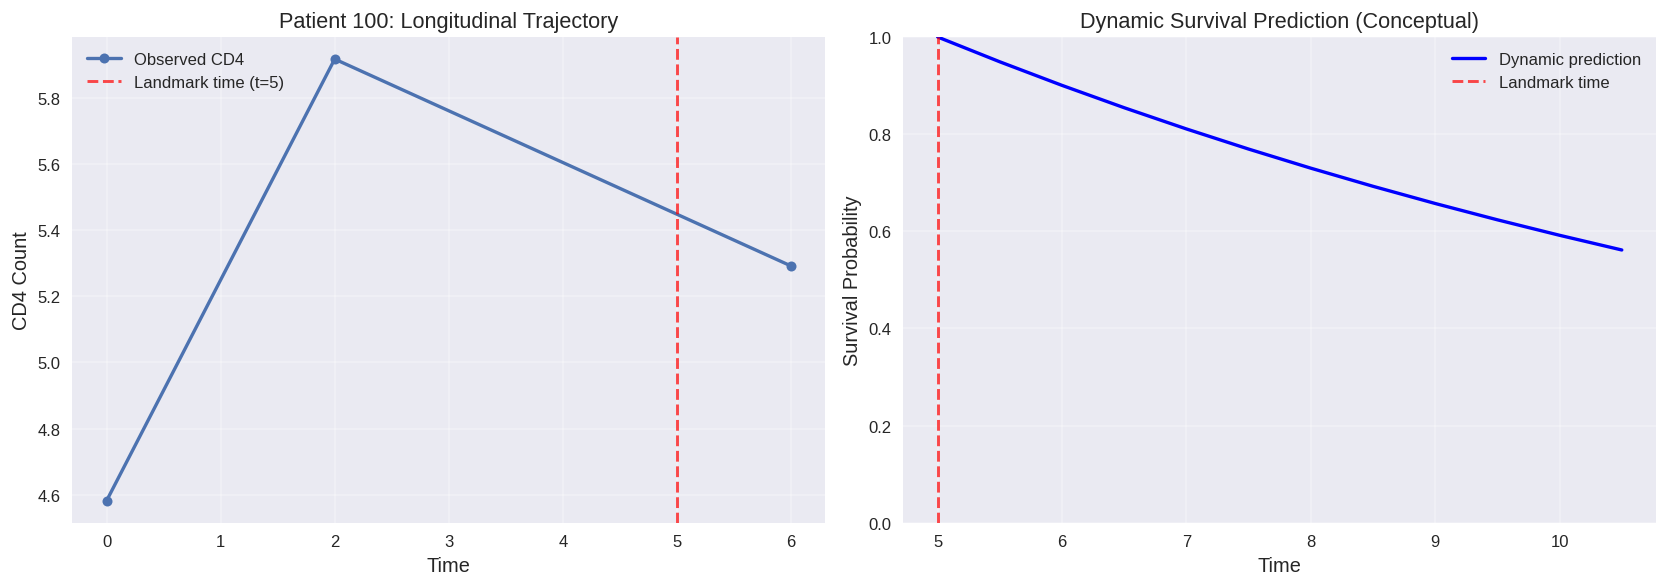


Note: These are conceptual visualizations.
Real dynamic predictions would:
1. Use the fitted joint model
2. Account for uncertainty in random effects
3. Update as new biomarker measurements arrive


In [ ]:
# Visualize predicted survival curves
# Since we don't have the full joint model predictions, we'll create
# a conceptual visualization showing how predictions might update

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Longitudinal trajectory
ax1 = axes[0]
patient_history = patientData.sort_values('obstime')
ax1.plot(patient_history['obstime'], patient_history['CD4'],
         'o-', linewidth=2, markersize=6, label='Observed CD4')
ax1.axvline(x=5, color='r', linestyle='--', alpha=0.7, label='Landmark time (t=5)')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('CD4 Count', fontsize=12)
ax1.set_title(f'Patient {patient_id}: Longitudinal Trajectory', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Conceptual survival predictions
ax2 = axes[1]
prediction_times = np.arange(5, 11, 0.5)

# Example survival probabilities (in practice, computed from joint model)
# These are illustrative - in reality they'd come from the joint model
baseline_survival = np.exp(-0.1 * (prediction_times - 5))
# Adjust based on patient's CD4 trajectory (conceptual)
cd4_factor = 1 - 0.05 * (patient_history['CD4'].iloc[-1] / 500 - 1)
adjusted_survival = baseline_survival ** cd4_factor

ax2.plot(prediction_times, adjusted_survival, 'b-', linewidth=2,
         label='Dynamic prediction')
ax2.axvline(x=5, color='r', linestyle='--', alpha=0.7, label='Landmark time')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Survival Probability', fontsize=12)
ax2.set_title('Dynamic Survival Prediction (Conceptual)', fontsize=13)
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: These are conceptual visualizations.")
print("Real dynamic predictions would:")
print("1. Use the fitted joint model")
print("2. Account for uncertainty in random effects")
print("3. Update as new biomarker measurements arrive")


This curve updates as the patient’s CD4 history is extended — illustrating **dynamic (real-time) prediction**.



### Dynamic predictive accuracy


Using the available longitudinal information up to a starting time point, `tvROV` fuctions compute estimates of the ROC curve and the AUC, the Brier score and expected predictive cross-entropy at a horizon time point based on joint models.


In [ ]:
# Dynamic Predictive Accuracy: Time-dependent ROC
# Evaluate predictive performance using time-dependent ROC curves

from sklearn.metrics import roc_curve, auc
# NOTE: The following line caused an ImportError since scipy no longer exposes interp directly.
# from scipy import interp
# Instead, use numpy.interp if interpolation is needed:
# from numpy import interp

print("=" * 60)
print("Time-dependent ROC Analysis")
print("=" * 60)

# Parameters
Tstart = 5  # Landmark time (e.g., year 5)
Dt = 3      # Prediction horizon (5 → 8 years)
Thorizon = Tstart + Dt  # Horizon time (8 years)

print(f"Landmark time: {Tstart}")
print(f"Prediction horizon: {Dt} years")
print(f"Horizon time: {Thorizon}\n")

# For time-dependent ROC, we need:
# 1. Patients at risk at landmark time Tstart
# 2. Their predicted risks at horizon time Thorizon
# 3. Their actual event status at Thorizon

# Filter patients who are at risk at Tstart
at_risk = aids_id[aids_id['Time'] > Tstart].copy()
print(f"Patients at risk at time {Tstart}: {len(at_risk)}")

# For demonstration, we'll use the Cox model predictions
# In a full joint model, we'd use dynamic predictions from the joint model

# Get predicted risks from Cox model
at_risk['predicted_risk'] = 1 - CoxFit.predict_survival_function(
    at_risk, times=[Thorizon]
).T.iloc[:, 0].values

# Define outcome: event occurred between Tstart and Thorizon
at_risk['outcome'] = ((at_risk['Time'] <= Thorizon) &
                      (at_risk[event_col] == 1)).astype(int)

print(f"Events between {Tstart} and {Thorizon}: {at_risk['outcome'].sum()}\n")

# Compute ROC curve
if at_risk['outcome'].sum() > 0 and at_risk['outcome'].sum() < len(at_risk):
    fpr, tpr, thresholds = roc_curve(at_risk['outcome'], at_risk['predicted_risk'])
    roc_auc = auc(fpr, tpr)

    print(f"Time-dependent AUC: {roc_auc:.3f}")

    # Store for plotting
    roc_results = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'thresholds': thresholds
    }
else:
    print("Warning: Insufficient events for ROC analysis")
    roc_results = None

Time-dependent ROC Analysis
Landmark time: 5
Prediction horizon: 3 years
Horizon time: 8

Patients at risk at time 5: 414
Events between 5 and 8: 6

Time-dependent AUC: 0.616


In [ ]:
# Print ROC results
if roc_results is not None:
    print("\nTime-dependent ROC Results:")
    print(f"AUC: {roc_results['auc']:.4f}")
    print(f"\nROC curve points (first 10):")
    roc_df = pd.DataFrame({
        'FPR': roc_results['fpr'][:10],
        'TPR': roc_results['tpr'][:10],
        'Threshold': roc_results['thresholds'][:10]
    })
    print(roc_df.to_string(index=False))

    # Compute Youden's index for optimal cutoff
    youden_index = roc_results['tpr'] - roc_results['fpr']
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = roc_results['thresholds'][optimal_idx]
    optimal_tpr = roc_results['tpr'][optimal_idx]
    optimal_fpr = roc_results['fpr'][optimal_idx]

    print(f"\nOptimal cutoff (Youden's index):")
    print(f"  Threshold: {optimal_threshold:.4f}")
    print(f"  Sensitivity (TPR): {optimal_tpr:.4f}")
    print(f"  1 - Specificity (FPR): {optimal_fpr:.4f}")
else:
    print("ROC analysis not available due to insufficient events")


Time-dependent ROC Results:
AUC: 0.6160

ROC curve points (first 10):
     FPR      TPR  Threshold
0.000000 0.000000        inf
0.039216 0.000000   0.260582
0.083333 0.000000   0.192936
0.531863 0.833333   0.095618
1.000000 1.000000   0.068874

Optimal cutoff (Youden's index):
  Threshold: 0.0956
  Sensitivity (TPR): 0.8333
  1 - Specificity (FPR): 0.5319


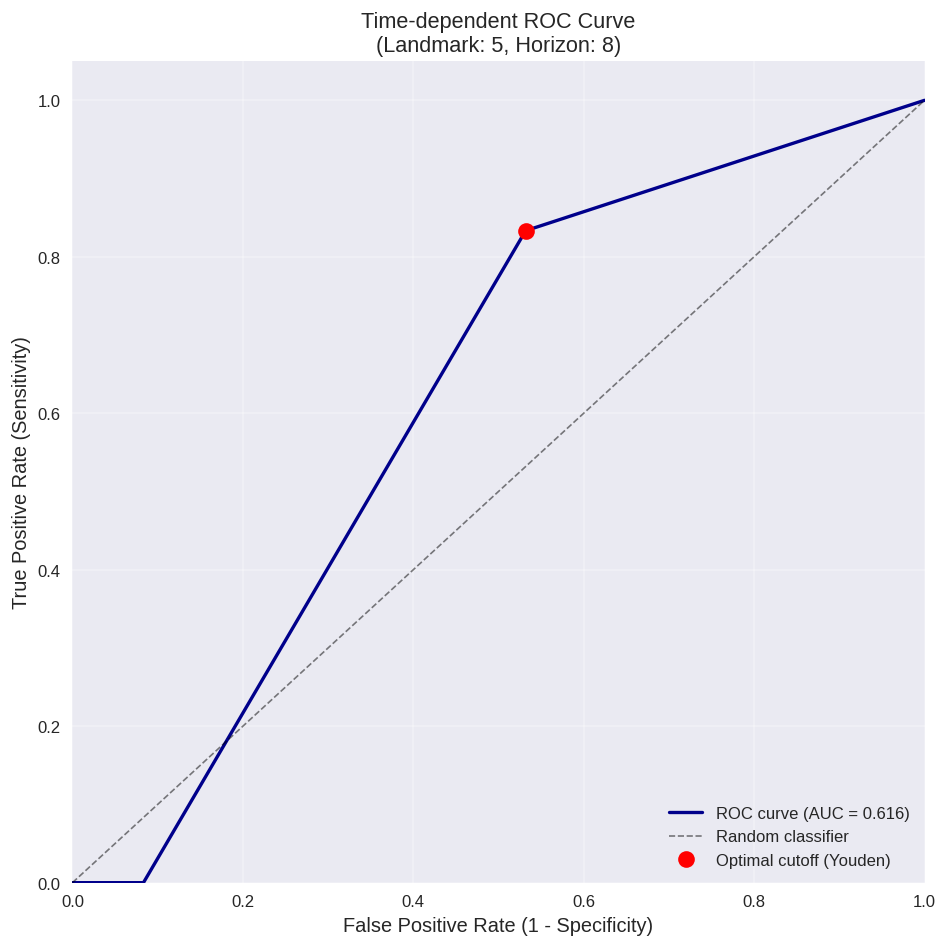


Time-dependent AUC: 0.6160


In [ ]:
# Plot ROC curve
if roc_results is not None:
    plt.figure(figsize=(8, 8))

    # Plot ROC curve
    plt.plot(roc_results['fpr'], roc_results['tpr'],
             color='darkblue', linewidth=2,
             label=f'ROC curve (AUC = {roc_results["auc"]:.3f})')

    # Plot diagonal (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random classifier')

    # Mark optimal cutoff (Youden's index)
    youden_index = roc_results['tpr'] - roc_results['fpr']
    optimal_idx = np.argmax(youden_index)
    plt.plot(roc_results['fpr'][optimal_idx], roc_results['tpr'][optimal_idx],
             'ro', markersize=10, label='Optimal cutoff (Youden)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title(f'Time-dependent ROC Curve\n(Landmark: {Tstart}, Horizon: {Thorizon})',
              fontsize=13)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nTime-dependent AUC: {roc_results['auc']:.4f}")
else:
    print("Cannot plot ROC curve: insufficient events for analysis")

## Summary and Conclusion


The Dynamic Joint Model extends the standard joint modeling framework by allowing the association between longitudinal biomarkers and survival risk to vary over time. This flexibility enables more accurate and personalized risk predictions that adapt as new biomarker data are collected. This tutorial demonstrated how to fit and interpret a **Dynamic Joint Model** in Python using available packages (`lifelines`, `statsmodels`, `scikit-learn`). At the end of tutorial you should be able to:

-  Understand the concept of dynamic joint modeling and its advantages over standard joint models.
-  Fit longitudinal and survival submodels using Python packages.
-  Understand how to implement dynamic joint models (note: full implementation may require custom code or PyMC).
-  Generate and interpret dynamic survival predictions that update with new longitudinal data.
-  Evaluate the predictive accuracy using time-dependent ROC curves and AUC.
-  Appreciate the clinical utility of dynamic joint models for personalized medicine.

> **Important Note**: Python doesn't have a direct equivalent to R's `JMbayes2` package. For production use, consider:
> - Using `rpy2` to call R's `JMbayes2` from Python
> - Implementing custom joint models using `PyMC` for Bayesian inference
> - Using specialized packages like `joineRML` (if available) or developing custom MLE implementations


##  Resources


* Rizopoulos D. (2012). *Joint Models for Longitudinal and Time-to-Event Data*. Chapman & Hall/CRC.
* Rizopoulos D. (2023). *JMbayes2: Joint Models for Longitudinal and Survival Data using Bayesian Methods.*
* Proust-Lima, C., et al. (2014). *Joint modelling of multivariate longitudinal outcomes and time-to-event: a review.* Statistical Methods in Medical Research.
* [JMbayes2: Extended Joint Models for Longitudinal and Time-to-Event Data](https://drizopoulos.github.io/JMbayes2/index.html) (R package)

**Python Resources:**
* [lifelines Documentation](https://lifelines.readthedocs.io/) - Survival analysis in Python
* [statsmodels Documentation](https://www.statsmodels.org/) - Statistical modeling including mixed effects
* [PyMC Documentation](https://www.pymc.io/) - Bayesian modeling in Python
* [scikit-survival](https://scikit-survival.readthedocs.io/) - Survival analysis with scikit-learn
* [rpy2 Documentation](https://rpy2.github.io/) - Interface to use R from Python






